In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import os
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2024"

maddat = madrigalWeb.madrigalWeb.MadrigalData('https://data.amisr.com/madrigal/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2019,1,1,0,0,0)
et=datetime.datetime(2019,1,2,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 30000725
realUrl: http://data.amisr.com/madrigal/showExperiment/?experiment_list=30000725
url: http://data.amisr.com/madrigal/madtoc/experiments0/2018/pfa/31dec18g
name: WorldDay35 - Auroral and convection measurements
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2018
startmonth: 12
startday: 31
starthour: 23
startmin: 48
startsec: 8
endyear: 2019
endmonth: 1
endday: 4
endhour: 12
endmin: 0
endsec: 4
isLocal: True
madrigalUrl: http://https://data.amisr.com/madrigal
PI: Asti Bhatt
PIEmail: asti.bhatt@sri.com
uttimestamp: 1689403860
access: 0
Madrigal version: 3.4



In [5]:
# Get all the files associated with the experiment:
fileList = maddat.getExperimentFiles(expList[0].id)
for file in fileList:
    print(os.path.basename(file.name),'\tkindat:',file.kindat,'desc:',file.kindatdesc)

pfa20181231.007_ac_nenotr_01min.001.h5 	kindat: 1000201 desc: Ne From Power - Alternating Code (E-region) - 1 min
pfa20181231.007_ac_fit_01min.001.h5 	kindat: 2000201 desc: Fitted - Alternating Code (E-region) - 1 min
pfa20181231.007_lp_nenotr_01min.001.h5 	kindat: 1000101 desc: Ne From Power - Long Pulse (F-region) - 1 min
pfa20181231.007_lp_fit_01min.001.h5 	kindat: 2000101 desc: Fitted - Long Pulse (F-region) - 1 min
pfa20181231.007_lp_vvels_03min.001.h5 	kindat: 3000103 desc: Resolved Velocity - Long Pulse (F-region) - 3 min
pfa20181231.007_lp_vvels_01min.001.h5 	kindat: 3000101 desc: Resolved Velocity - Long Pulse (F-region) - 1 min


In [6]:
vvelsfile=None
acfile=None
lpfile=None
for file in fileList:
    if 'Resolved Velocity' in file.kindatdesc:
        if 'F-region' in  file.kindatdesc:
            if '1 min' in  file.kindatdesc:
                vvelsfile=file
    elif 'Fitted' in file.kindatdesc:
        if 'E-region' in  file.kindatdesc:
            if '1 min' in  file.kindatdesc:
                acfile=file
        elif 'F-region' in  file.kindatdesc:
            if '1 min' in  file.kindatdesc:
                lpfile=file

vvelsfilename=vvelsfile.name
vvelsoutfilename=os.path.basename(vvelsfile.name)
result = maddat.downloadFile(vvelsfilename,vvelsoutfilename, user_fullname, user_email, user_affiliation, 'hdf5')        
        
lpfilename=lpfile.name
lpoutfilename=os.path.basename(lpfile.name)
result = maddat.downloadFile(lpfilename,lpoutfilename, user_fullname, user_email, user_affiliation, 'hdf5')        
        
acfilename=acfile.name
acoutfilename=os.path.basename(acfile.name)
result = maddat.downloadFile(acfilename,acoutfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [7]:
with h5py.File(vvelsoutfilename,'r') as f:
    vvels_data = []
    dat=f['Data/Array Layout']
    outdct={}

    outdct['vipn'] = dat['2D Parameters/vipn'][:]
    outdct['dvipn'] = dat['2D Parameters/dvipn'][:]
    outdct['vipe'] = dat['2D Parameters/vipe'][:]
    outdct['dvipe'] = dat['2D Parameters/dvipe'][:]

    outdct['cgm_lat'] = dat['cgm_lat'][:]
    tstmp = dat['timestamps'][:]
    outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
    vvels_data.append(outdct)

In [8]:
with h5py.File(acoutfilename,'r') as f:
    AC_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] =  dat['2D Parameters/ne'][:]
        outdct['dne'] = dat['2D Parameters/dne'][:]
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        AC_data.append(outdct)

In [9]:
with h5py.File(lpoutfilename,'r') as f:
    LP_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] =  dat['2D Parameters/ne'][:]
        outdct['dne'] = dat['2D Parameters/dne'][:]
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        LP_data.append(outdct)

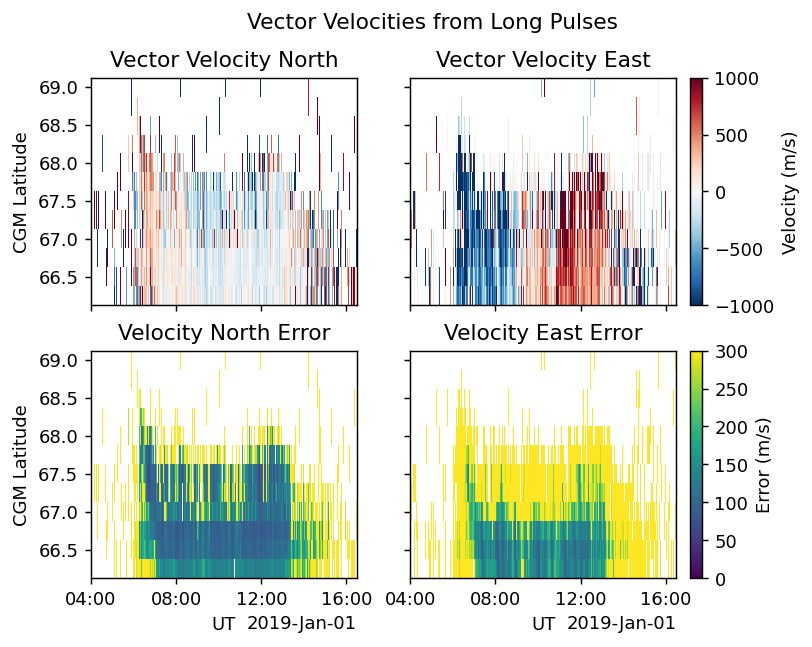

In [10]:
vdat=vvels_data[0]
fig,axarr=plt.subplots(2,2, figsize=(7,5), dpi=130,sharex=True,sharey=True)

vclrs=axarr[0,0].pcolormesh(mdates.date2num(vdat['time']),vdat['cgm_lat'],vdat['vipn'],
                            vmin=-1000,vmax=1000,cmap='RdBu_r',shading='nearest')
errclrs=axarr[1,0].pcolormesh(mdates.date2num(vdat['time']),vdat['cgm_lat'],vdat['dvipn'],
                              vmin=0,vmax=300,cmap='viridis',shading='nearest')

vclrs=axarr[0,1].pcolormesh(mdates.date2num(vdat['time']),vdat['cgm_lat'],vdat['vipe'],
                            vmin=-1000,vmax=1000,cmap='RdBu_r',shading='nearest')
errclrs=axarr[1,1].pcolormesh(mdates.date2num(vdat['time']),vdat['cgm_lat'],vdat['dvipe'],
                              vmin=0,vmax=300,cmap='viridis',shading='nearest')

locator = mdates.AutoDateLocator(minticks=3, maxticks=4)
formatter = mdates.ConciseDateFormatter(locator)
axarr[1,1].xaxis.set_major_locator(locator)
axarr[1,1].xaxis.set_major_formatter(formatter)
axarr[1,1].set_xlabel('UT')
axarr[1,0].set_xlabel('UT')
axarr[1,1].set_xlim([mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),
                     mdates.date2num(datetime.datetime(2019,1,1,16,30,0))])

axarr[0,0].set_ylabel('CGM Latitude')
axarr[1,0].set_ylabel('CGM Latitude')

axarr[0,0].set_title('Vector Velocity North')
axarr[0,1].set_title('Vector Velocity East')

axarr[1,0].set_title('Velocity North Error')
axarr[1,1].set_title('Velocity East Error')

fig.suptitle('Vector Velocities from Long Pulses')

vcb=fig.colorbar(vclrs,ax=[axarr[0,0],axarr[0,1]], pad=0.02)
vcb.set_label('Velocity (m/s)')

errcb=plt.colorbar(errclrs,ax=[axarr[1,0],axarr[1,1]], pad=0.02)
errcb.set_label('Error (m/s)')

In [11]:
for i,d in enumerate(LP_data):
    print(f"{d['bid']} {d['azm']:.2f} {d['elm']:.2f}")

63197 -35.09 66.19
63239 -16.23 58.68
63281 -2.95 47.55
63365 76.09 66.19
63401 57.23 58.68
63449 43.95 47.55
64016 14.04 90.00
64037 20.50 76.00
64055 20.50 64.00
64079 20.50 50.00
64157 -154.30 77.50


In [12]:
#Pick out three beams
east_ac_ind  = np.argmin(np.abs(np.array([x['azm'] for x in AC_data]) - ( 57.23)))
eacdat    = AC_data[east_ac_ind]

east_lp_ind  = np.argmin(np.abs(np.array([x['azm'] for x in LP_data]) - ( 57.23)))
elpdat    = LP_data[east_lp_ind]

bnorth_ac_ind = np.argmin(np.abs(np.array([x['elm'] for x in AC_data]) - ( 50.0)))
nacdat    = AC_data[bnorth_ac_ind]

bnorth_lp_ind = np.argmin(np.abs(np.array([x['elm'] for x in LP_data]) - ( 50.0)))
nlpdat    = LP_data[bnorth_lp_ind]

bwest_ac_ind = np.argmin(np.abs(np.array([x['azm'] for x in AC_data]) - (-16.23)))
wacdat    = AC_data[bwest_ac_ind]

bwest_lp_ind = np.argmin(np.abs(np.array([x['azm'] for x in LP_data]) - (-16.23)))
wlpdat    = LP_data[bwest_lp_ind]

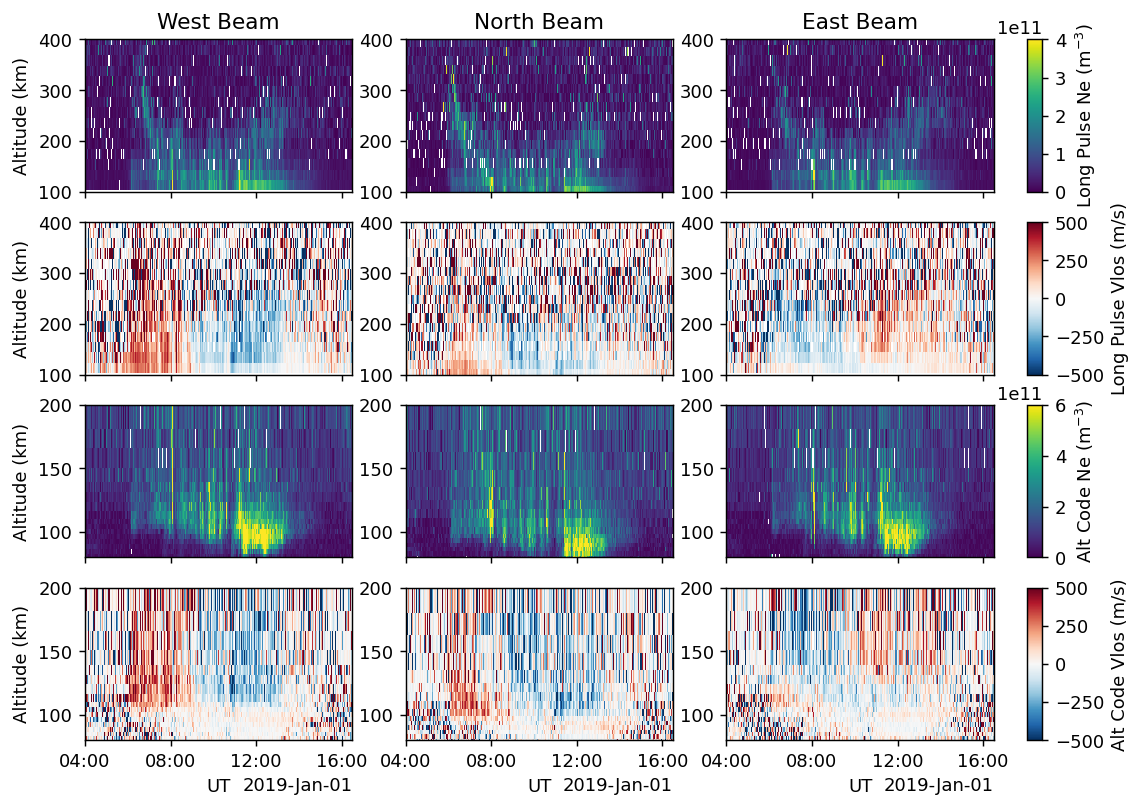

In [13]:
rows = 4
fig,axarr=plt.subplots(rows,3,dpi=130,figsize=(11,7),sharex=True, gridspec_kw=dict(wspace=0.2, hspace=0.2))

for row,(datatype,beamrmodes,cbtxt,datalims,ylims,cmap) in enumerate(zip(
                 ['ne','vo','ne','vo'],
                 [[wlpdat,nlpdat,elpdat],[wlpdat,nlpdat,elpdat],[wacdat,nacdat,eacdat],[wacdat,nacdat,eacdat]],
                 [r"Long Pulse Ne (m$^{-3}$)", "Long Pulse Vlos (m/s)",
                   r"Alt Code Ne (m$^{-3}$)", "Alt Code Vlos (m/s)"],
                 [[0,4e11],[-500,500],[0,6e11],[-500,500]],
                 [[100,400],[100,400],[80,200],[80,200]],
                 ['viridis','RdBu_r','viridis','RdBu_r'])):
    for col,beamrmode in enumerate(beamrmodes):
        ax = axarr[row][col]
        pcm = ax.pcolormesh(mdates.date2num(beamrmode['time']),beamrmode['altitude']/1e3,beamrmode[datatype],
                      vmin=datalims[0],vmax=datalims[1],cmap=cmap,shading='nearest')
        ax.set_ylim(ylims)
        if col==0:
            ax.set_ylabel('Altitude (km)')
            vcb=fig.colorbar(pcm,ax=list(axarr[row][:].ravel()), pad=0.03, aspect=10)
            vcb.set_label(cbtxt)
        if row == rows-1:
            ax.set_xlabel('UT')            

axarr[0,0].set_title('West Beam')
axarr[0,1].set_title('North Beam')
axarr[0,2].set_title('East Beam')

locator = mdates.AutoDateLocator(minticks=3, maxticks=4)
formatter = mdates.ConciseDateFormatter(locator)
axarr[-1,-1].xaxis.set_major_locator(locator)
axarr[-1,-1].xaxis.set_major_formatter(formatter)
axarr[-1,-1].set_xlim([mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),
                      mdates.date2num(datetime.datetime(2019,1,1,16,30,0))]);


# Questions

1. What is happening with resolved vector velocities (first plot) before and after 9 UT? (Hint, you may find it helpful to look up the large-scale SuperDARN convection pattern from this time for comparison. http://vt.superdarn.org/plot/map).

2. How do the line-of-sight velocities from individual beams (second plot) compare to the resolved velocities? (Note, positive line-of-sight velocity means away from the radar).

3. Why are the resolved velocity errors so large at the beginning (before 6 UT) and end (after 14 UT) of this interval?

## Extra Questions

4. What is happening to the line-of-sight velocities below 120 km? This change is especially clear in the alternating code line-of-sight data.